In [1]:
# Torch
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Dict, List

# Data manipulation
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path

# File I/O and system interaction
import os
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Math and Science libraries
from scipy.io import loadmat

# Performance measurement
from timeit import default_timer as timer

# Print PyTorch Version
print(torch.__version__)


2.2.2+cpu


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data preparation

In [3]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "stanford_cars"

In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 5 images in 'data\stanford_cars'.
There are 196 directories and 0 images in 'data\stanford_cars\test'.
There are 0 directories and 44 images in 'data\stanford_cars\test\Acura Integra Type R 2001'.
There are 0 directories and 32 images in 'data\stanford_cars\test\Acura RL Sedan 2012'.
There are 0 directories and 43 images in 'data\stanford_cars\test\Acura TL Sedan 2012'.
There are 0 directories and 42 images in 'data\stanford_cars\test\Acura TL Type-S 2008'.
There are 0 directories and 40 images in 'data\stanford_cars\test\Acura TSX Sedan 2012'.
There are 0 directories and 39 images in 'data\stanford_cars\test\Acura ZDX Hatchback 2012'.
There are 0 directories and 44 images in 'data\stanford_cars\test\AM General Hummer SUV 2000'.
There are 0 directories and 45 images in 'data\stanford_cars\test\Aston Martin V8 Vantage Convertible 2012'.
There are 0 directories and 41 images in 'data\stanford_cars\test\Aston Martin V8 Vantage Coupe 2012'.
There are 0 directori

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
train_dir

WindowsPath('data/stanford_cars/train')

## Visualize an image

Random image path: data\stanford_cars\train\Honda Accord Coupe 2012\05308.jpg
Image class: Honda Accord Coupe 2012
Image height: 326
Image width: 576


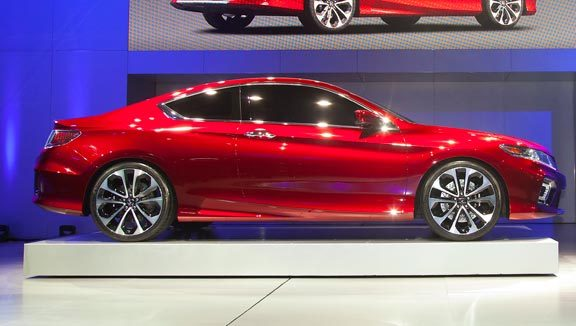

In [7]:

# Set seed
# random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

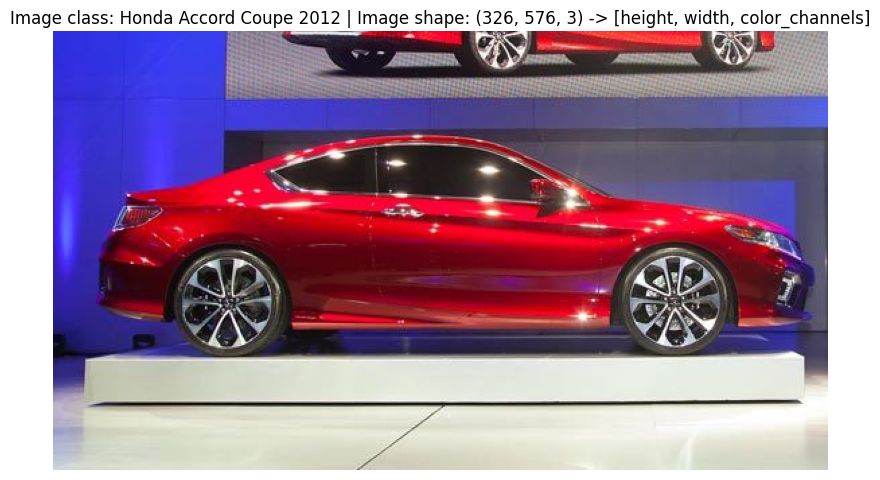

In [8]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Transforming data

In [9]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

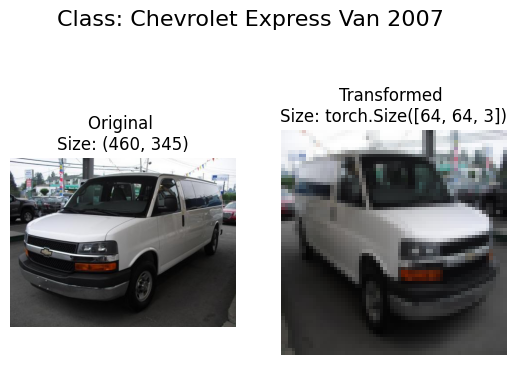

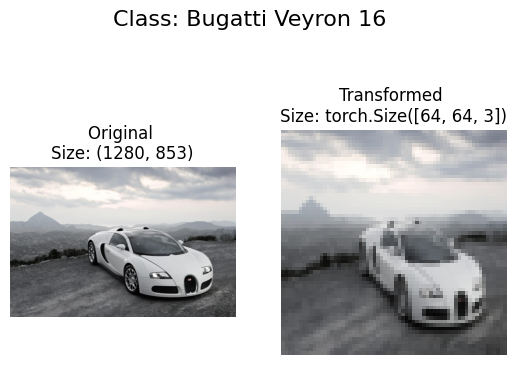

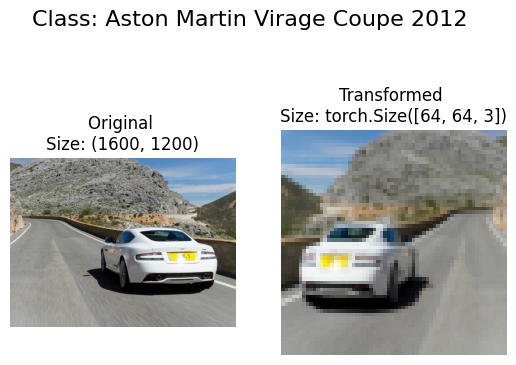

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# Loading Image Data Using ImageFolder

In [11]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)


print(f"Train data:\n{train_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8144
    Root location: data\stanford_cars\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [14]:
# Check the lengths
len(train_data)

8144

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.99

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


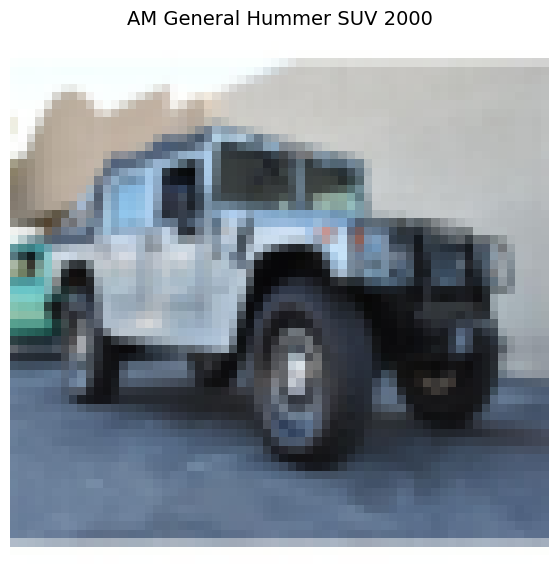

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# Turn loaded images into DataLoader'

In [17]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
train_dataloader

In [18]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Loading Image Data with a Custom Dataset

In [19]:
train_data.classes, train_data.class_to_idx

(['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008',
  'Acura TSX Sedan 2012',
  'Acura ZDX Hatchback 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin Virage Convertible 2012',
  'Aston Martin Virage Coupe 2012',
  'Audi 100 Sedan 1994',
  'Audi 100 Wagon 1994',
  'Audi A5 Coupe 2012',
  'Audi R8 Coupe 2012',
  'Audi RS 4 Convertible 2008',
  'Audi S4 Sedan 2007',
  'Audi S4 Sedan 2012',
  'Audi S5 Convertible 2012',
  'Audi S5 Coupe 2012',
  'Audi S6 Sedan 2011',
  'Audi TT Hatchback 2011',
  'Audi TT RS Coupe 2012',
  'Audi TTS Coupe 2012',
  'Audi V8 Sedan 1994',
  'BMW 1 Series Convertible 2012',
  'BMW 1 Series Coupe 2012',
  'BMW 3 Series Sedan 2012',
  'BMW 3 Series Wagon 2012',
  'BMW 6 Series Convertible 2007',
  'BMW ActiveHybrid 5 Sedan 2012',
  'BMW M3 Coupe 2012',
  'BMW M5 Sedan 2010',
  'BMW M6 Convertible 2010',
  'BMW X3 SUV 

## Creating a helper function to get class names

In [20]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target directory: data\stanford_cars\train
Class names found: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 

In [21]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [22]:
find_classes(train_dir)

(['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008',
  'Acura TSX Sedan 2012',
  'Acura ZDX Hatchback 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin Virage Convertible 2012',
  'Aston Martin Virage Coupe 2012',
  'Audi 100 Sedan 1994',
  'Audi 100 Wagon 1994',
  'Audi A5 Coupe 2012',
  'Audi R8 Coupe 2012',
  'Audi RS 4 Convertible 2008',
  'Audi S4 Sedan 2007',
  'Audi S4 Sedan 2012',
  'Audi S5 Convertible 2012',
  'Audi S5 Coupe 2012',
  'Audi S6 Sedan 2011',
  'Audi TT Hatchback 2011',
  'Audi TT RS Coupe 2012',
  'Audi TTS Coupe 2012',
  'Audi V8 Sedan 1994',
  'BMW 1 Series Convertible 2012',
  'BMW 1 Series Coupe 2012',
  'BMW 3 Series Sedan 2012',
  'BMW 3 Series Wagon 2012',
  'BMW 6 Series Convertible 2007',
  'BMW ActiveHybrid 5 Sedan 2012',
  'BMW M3 Coupe 2012',
  'BMW M5 Sedan 2010',
  'BMW M6 Convertible 2010',
  'BMW X3 SUV 

## Create a custom Dataset to replicate ImageFolder¶

In [23]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [24]:

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


In [25]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
train_data_custom

In [26]:
len(train_data_custom)

8103

In [27]:
train_data_custom.classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [28]:
train_data_custom.class_to_idx

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [29]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

False
True
True


# Create function to display random images

In [30]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

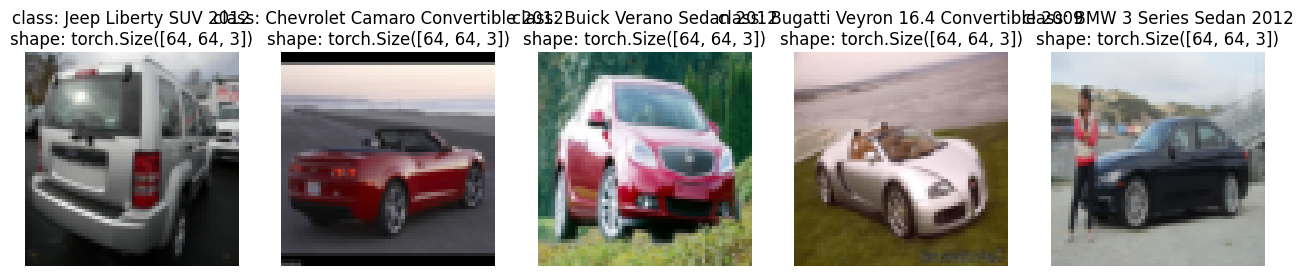

In [31]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


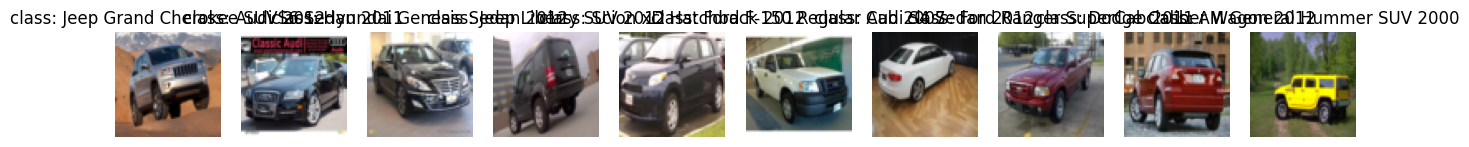

In [32]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

# Turn custom loaded images into DataLoader

In [33]:
# Turn train and test custom Dataset's into DataLoader's
# from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?


train_dataloader_custom

In [34]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other forms of transforms (data augmentation)

## Transforming data with torchvision.transforms

In [35]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

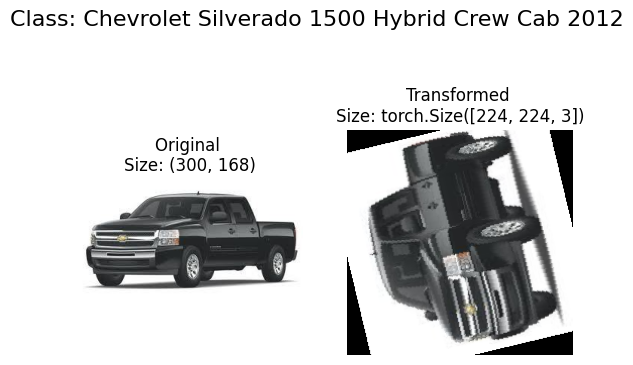

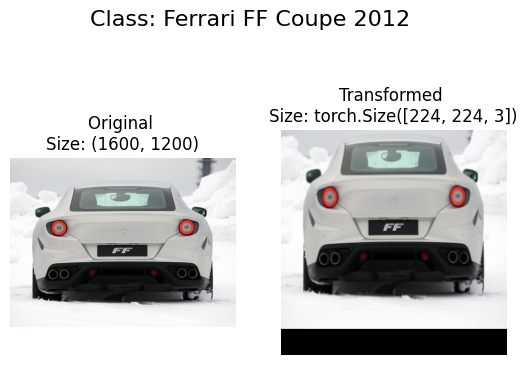

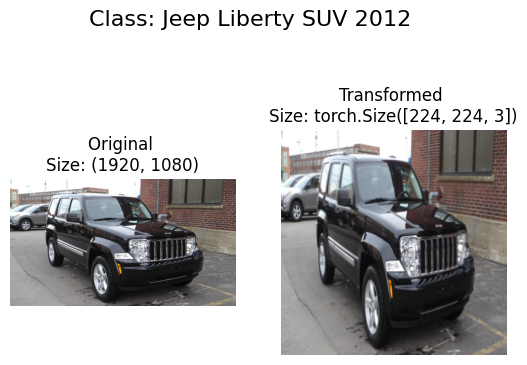

In [36]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0: TinyVGG without data augmentation

## Creating transforms and loading data for Model 0

In [37]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [38]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
# test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
# import os
# from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

# test_dataloader_simple = DataLoader(test_data_simple, 
#                                     batch_size=BATCH_SIZE, 
#                                     shuffle=False, 
#                                     num_workers=NUM_WORKERS)

train_dataloader_simple#, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


## Create TinyVGG model class

In [39]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=196, bias=True)
  )
)

##  Try a forward pass on a single image (to test the model)

In [40]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0650,  0.0576,  0.0396, -0.0296, -0.0503,  0.0532, -0.0812,  0.0937,
         -0.0115,  0.0598, -0.0365, -0.0371,  0.0110, -0.0443,  0.0721, -0.0042,
         -0.0130,  0.0272,  0.0162,  0.0705, -0.0098, -0.0276,  0.0214, -0.0079,
          0.0406,  0.0859,  0.0265,  0.0354,  0.0040, -0.0544, -0.0007,  0.0858,
          0.0017, -0.0953, -0.0307,  0.0003, -0.0278, -0.0328,  0.0120, -0.0233,
          0.0209, -0.0310,  0.0297,  0.0667, -0.0175, -0.0159,  0.0709,  0.0386,
          0.0375,  0.0266, -0.0088, -0.0314, -0.0274,  0.0262, -0.0068, -0.0327,
         -0.0071,  0.0284,  0.0286, -0.0085, -0.0620,  0.0163, -0.0109, -0.0479,
          0.0217,  0.0549, -0.0342,  0.0312,  0.0313,  0.0373,  0.0170, -0.0354,
         -0.0187,  0.0092,  0.0406,  0.0012,  0.0415, -0.0331, -0.0031, -0.0154,
          0.0039, -0.0248,  0.0051,  0.0338, -0.0488,  0.0088,  0.0173, -0.0157,
         -0.0132,  0.0215, -0.0762,  0.1001,  

# Use torchinfo to get an idea of the shapes going through our model

In [41]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 196]                  --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Create train & test loop functions

In [42]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

## Creating a train() function to combine train_step() and test_step()

In [43]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
        #   test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        # "test_loss": [],
        # "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        # test_loss, test_acc = test_step(model=model,
        #     dataloader=test_dataloader,
        #     loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            # f"test_loss: {test_loss:.4f} | "
            # f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        # results["test_loss"].append(test_loss)
        # results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\dev\Python\cv_model\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train and Evaluate Model 0

In [44]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        # test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:49<24:01, 49.72s/it]

Epoch: 1 | train_loss: 5.2815 | train_acc: 0.0058 | 


  7%|▋         | 2/30 [01:42<23:57, 51.34s/it]

Epoch: 2 | train_loss: 5.2778 | train_acc: 0.0083 | 


 10%|█         | 3/30 [02:42<24:52, 55.29s/it]

Epoch: 3 | train_loss: 5.2772 | train_acc: 0.0081 | 


 13%|█▎        | 4/30 [03:48<25:51, 59.69s/it]

Epoch: 4 | train_loss: 5.2765 | train_acc: 0.0083 | 


 17%|█▋        | 5/30 [04:57<26:14, 63.00s/it]

Epoch: 5 | train_loss: 5.2759 | train_acc: 0.0083 | 


 20%|██        | 6/30 [05:56<24:37, 61.57s/it]

Epoch: 6 | train_loss: 5.2746 | train_acc: 0.0077 | 


 23%|██▎       | 7/30 [06:55<23:14, 60.64s/it]

Epoch: 7 | train_loss: 5.2277 | train_acc: 0.0135 | 


 27%|██▋       | 8/30 [07:54<22:05, 60.24s/it]

Epoch: 8 | train_loss: 5.0305 | train_acc: 0.0297 | 


 30%|███       | 9/30 [08:57<21:21, 61.02s/it]

Epoch: 9 | train_loss: 4.3480 | train_acc: 0.1120 | 


 33%|███▎      | 10/30 [10:02<20:49, 62.48s/it]

Epoch: 10 | train_loss: 2.9420 | train_acc: 0.3570 | 


 37%|███▋      | 11/30 [11:07<19:58, 63.07s/it]

Epoch: 11 | train_loss: 1.8730 | train_acc: 0.5770 | 


 40%|████      | 12/30 [12:04<18:21, 61.17s/it]

Epoch: 12 | train_loss: 1.2085 | train_acc: 0.7254 | 


 43%|████▎     | 13/30 [12:56<16:36, 58.64s/it]

Epoch: 13 | train_loss: 0.7873 | train_acc: 0.8241 | 


 47%|████▋     | 14/30 [13:47<14:59, 56.22s/it]

Epoch: 14 | train_loss: 0.5296 | train_acc: 0.8853 | 


 50%|█████     | 15/30 [14:37<13:36, 54.41s/it]

Epoch: 15 | train_loss: 0.3584 | train_acc: 0.9256 | 


 53%|█████▎    | 16/30 [15:25<12:13, 52.38s/it]

Epoch: 16 | train_loss: 0.2522 | train_acc: 0.9487 | 


 57%|█████▋    | 17/30 [16:14<11:06, 51.27s/it]

Epoch: 17 | train_loss: 0.1896 | train_acc: 0.9635 | 


 60%|██████    | 18/30 [17:02<10:03, 50.31s/it]

Epoch: 18 | train_loss: 0.1553 | train_acc: 0.9700 | 


 63%|██████▎   | 19/30 [17:38<08:27, 46.18s/it]

Epoch: 19 | train_loss: 0.1254 | train_acc: 0.9768 | 


 67%|██████▋   | 20/30 [18:12<07:05, 42.51s/it]

Epoch: 20 | train_loss: 0.1091 | train_acc: 0.9800 | 


 70%|███████   | 21/30 [19:01<06:39, 44.43s/it]

Epoch: 21 | train_loss: 0.0943 | train_acc: 0.9830 | 


 73%|███████▎  | 22/30 [19:51<06:08, 46.10s/it]

Epoch: 22 | train_loss: 0.0943 | train_acc: 0.9850 | 


 77%|███████▋  | 23/30 [20:40<05:29, 47.02s/it]

Epoch: 23 | train_loss: 0.0897 | train_acc: 0.9837 | 


 80%|████████  | 24/30 [23:35<08:31, 85.22s/it]

Epoch: 24 | train_loss: 0.0757 | train_acc: 0.9869 | 


 83%|████████▎ | 25/30 [24:35<06:28, 77.72s/it]

Epoch: 25 | train_loss: 0.0727 | train_acc: 0.9882 | 


 87%|████████▋ | 26/30 [25:33<04:46, 71.72s/it]

Epoch: 26 | train_loss: 0.0703 | train_acc: 0.9885 | 


 90%|█████████ | 27/30 [26:29<03:21, 67.19s/it]

Epoch: 27 | train_loss: 0.0522 | train_acc: 0.9923 | 


 93%|█████████▎| 28/30 [27:26<02:08, 64.13s/it]

Epoch: 28 | train_loss: 0.0638 | train_acc: 0.9892 | 


 97%|█████████▋| 29/30 [28:25<01:02, 62.40s/it]

Epoch: 29 | train_loss: 0.0538 | train_acc: 0.9917 | 


100%|██████████| 30/30 [29:49<00:00, 59.66s/it]

Epoch: 30 | train_loss: 0.0624 | train_acc: 0.9914 | 
Total training time: 1789.706 seconds


## Plot the loss curves of Model 0

In [45]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc'])

In [46]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
            #  "test_loss": [...],
            #  "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    # test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    # test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    # plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    # plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

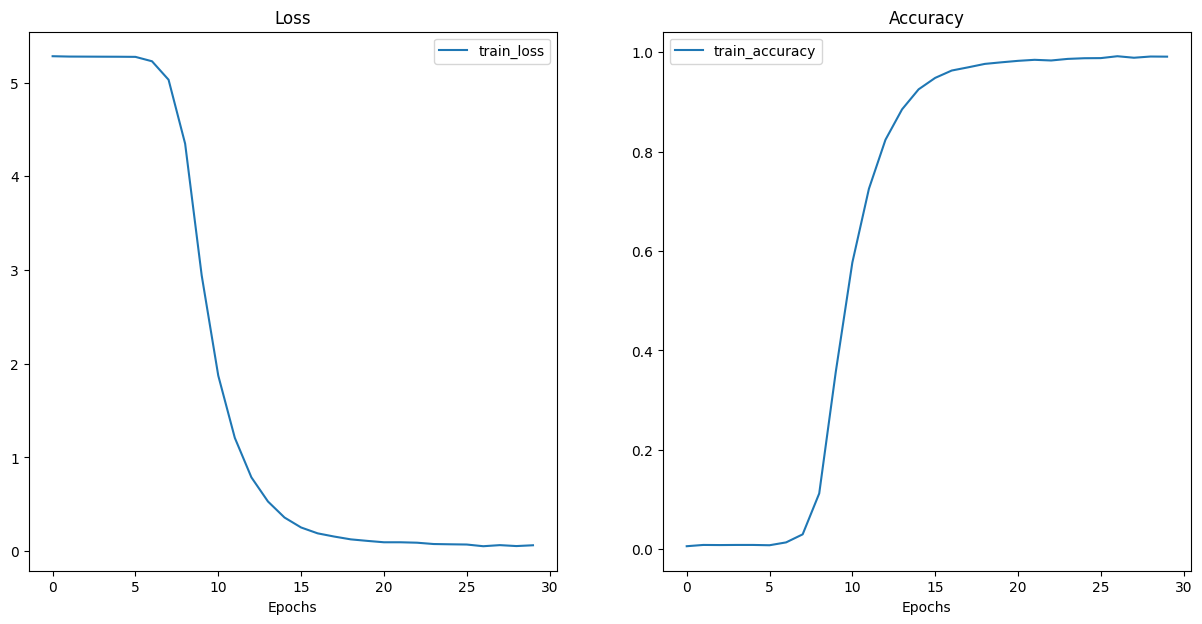

In [47]:
plot_loss_curves(model_0_results)